In [1]:
!git clone https://github.com/muxspace/facial_expressions.git

Cloning into 'facial_expressions'...
remote: Enumerating objects: 14214, done.
remote: Total 14214 (delta 0), reused 0 (delta 0), pack-reused 14214
Receiving objects: 100% (14214/14214), 239.65 MiB | 38.42 MiB/s, done.
Resolving deltas: 100% (223/223), done.
Updating files: 100% (13996/13996), done.


In [2]:
import csv
data = {}
with open('/content/facial_expressions/data/legend.csv') as f:
  reader = csv.reader(f)
  next(reader)
  for row in reader:
    key = row[2].lower()
    if key in data:
      data[key].append(row[1])
    else:
      data[key] = [row[1]]

In [3]:
emotion_list = list(data.keys())
emotion_list

['anger',
 'surprise',
 'disgust',
 'fear',
 'neutral',
 'happiness',
 'sadness',
 'contempt']

In [4]:
import os

os.mkdir('master_data')
os.mkdir('master_data/training')
os.mkdir('master_data/testing')

In [5]:
for emotion in emotion_list:
  os.mkdir(os.path.join('master_data/training/', emotion))
  os.mkdir(os.path.join('master_data/testing/', emotion))

In [6]:
from shutil import copyfile
split_size = 0.8

for emotion, images in data.items():
  train_size = int(split_size*len(images))
  train_images = images[:train_size]
  test_images = images[train_size:]
  for image in train_images:
    source = os.path.join('/content/facial_expressions/images', image)
    dest = os.path.join('/content/master_data/training', emotion, image)
    copyfile(source, dest)
  for image in test_images:
    source = os.path.join('/content/facial_expressions/images', image)
    dest = os.path.join('/content/master_data/testing', emotion, image)
    copyfile(source, dest)

In [7]:
import matplotlib.pyplot as plt
from matplotlib.image import imread

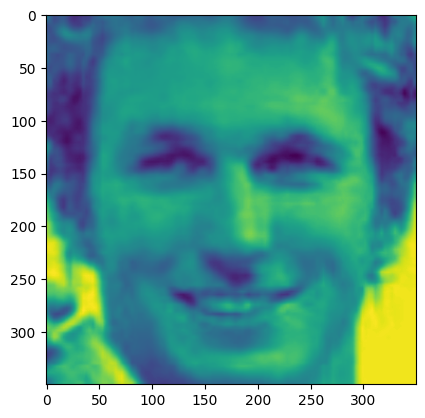

In [8]:
raw=data['happiness'][1]
image=imread('/content/master_data/training/happiness/'+raw)
plt.imshow(image)

In [9]:
image.shape

(350, 350)

In [10]:
image_size=(256,256)

In [11]:
import tensorflow as tf

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [13]:
trainDirectory='/content/master_data/training'
testDirectory='/content/master_data/testing'


In [14]:
trainGenerator=ImageDataGenerator(trainDirectory,
                                  rescale=1./255,
                                  horizontal_flip=True,
                                  shear_range=0.05)
testGenerator=ImageDataGenerator(testDirectory,
                                 rescale=1./255)

valGenerator=ImageDataGenerator(testDirectory,
                                rescale=1./255,)


In [15]:
training_images=trainGenerator.flow_from_directory(trainDirectory,
                                                   batch_size=32,
                                                   target_size=image_size,
                                                   class_mode='categorical')
validation_images=trainGenerator.flow_from_directory(testDirectory,
                                                   batch_size=32,
                                                   target_size=image_size,
                                                   class_mode='categorical')
testing_images=trainGenerator.flow_from_directory(testDirectory,
                                                   batch_size=32,
                                                   target_size=image_size,
                                                   class_mode='categorical')

Found 10941 images belonging to 8 classes.
Found 2742 images belonging to 8 classes.
Found 2742 images belonging to 8 classes.


In [16]:
!pip install -U efficientnet
import efficientnet.keras as efn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 6.1 MB/s eta 0:00:00


In [17]:
from tensorflow import keras

In [18]:
from keras import applications

In [19]:
from keras.models import Sequential

In [20]:
from keras.layers import Dense, Dropout, BatchNormalization, Flatten, Conv2D, MaxPooling2D

In [31]:
effnet=applications.efficientnet.EfficientNetB0(include_top=False,
                                                weights='imagenet',
                                                input_shape=(256,256,3),
                                                )
effnet.trainable=False


In [38]:
EfficientNet_model=Sequential()

EfficientNet_model.add(effnet)

EfficientNet_model.add(Flatten())

EfficientNet_model.add(Dense(1024, activation='relu'))
EfficientNet_model.add(Dropout(0.3))

EfficientNet_model.add(Dense(512, activation='relu'))
EfficientNet_model.add(Dropout(0.2))

EfficientNet_model.add(Dense(128, activation='relu'))
EfficientNet_model.add(Dropout(0.2))

EfficientNet_model.add(Dense(8, activation='softmax'))


In [23]:
from keras.callbacks import EarlyStopping

In [24]:
earlyStop=EarlyStopping(patience=2,
                        monitor='val_loss')

In [39]:
EfficientNet_model.compile(loss='categorical_crossentropy',metrics=['accuracy'], optimizer='adam')

In [53]:
result=EfficientNet_model.fit(training_images,
                              validation_data=validation_images,
                              callbacks=[earlyStop],
                              epochs=1)

/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


342/342 [==============================] - ETA: 0s - loss: 1.0728 - accuracy: 0.4945

KeyboardInterrupt: ignored

In [ ]:
vgg=applications.vgg16.VGG16(include_top=False,
                             weights='imagenet',
                             input_shape=(256,256,3))
vgg.trainable=False

model2=Sequential()


model2.add(vgg)

model2.add(Flatten())

model2.add(Dense(1024,activation='relu'))
model2.add(Dropout(0.3))

model2.add(Dense(256,activation='relu'))
model2.add(Dropout(0.3))

model2.add(Dense(8,activation='softmax'))

model2.compile(loss='categorical_crossentropy',metrics=['accuracy'], optimizer='adam')

result=model2.fit(training_images,
                 validation_data=validation_images,
                 epochs=15)

In [47]:
from keras import layers
from keras import models

model_aug = models.Sequential()
model_aug.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(256, 256, 3)))
model_aug.add(layers.MaxPooling2D((2, 2)))
#model_aug.add(layers.Dropout(0.5))

model_aug.add(layers.Conv2D(32, (3, 3), activation='relu'))
model_aug.add(layers.BatchNormalization())
model_aug.add(layers.MaxPooling2D((2, 2)))
#model_aug.add(layers.Dropout(0.2))

model_aug.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_aug.add(layers.MaxPooling2D((2, 2)))
model_aug.add(layers.Dropout(0.2))

model_aug.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_aug.add(layers.BatchNormalization())
model_aug.add(layers.MaxPooling2D((2, 2)))

model_aug.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_aug.add(layers.MaxPooling2D((2, 2)))

model_aug.add(layers.Flatten())
model_aug.add(layers.Dense(512, activation='relu'))
model_aug.add(layers.Dropout(0.3))
model_aug.add(layers.Dense(128, activation='relu'))
model_aug.add(layers.Dropout(0.2))
model_aug.add(layers.Dense(8, activation='softmax'))

model_aug.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

hist_aug=model_aug.fit(
      training_images,
    batch_size=32,
     # steps_per_epoch=len(train)//128,
      epochs=10,
      validation_data=validation_images)
      #validation_steps=len(val)//128)

Epoch 1/10
342/342 [==============================] - 200s 572ms/step - loss: 0.8934 - accuracy: 0.7038 - val_loss: 1.6780 - val_accuracy: 0.5853
Epoch 2/10
342/342 [==============================] - 198s 579ms/step - loss: 0.5873 - accuracy: 0.8097 - val_loss: 2.0907 - val_accuracy: 0.5408
Epoch 3/10
342/342 [==============================] - 196s 574ms/step - loss: 0.4997 - accuracy: 0.8335 - val_loss: 1.1320 - val_accuracy: 0.6608
Epoch 4/10
342/342 [==============================] - 196s 575ms/step - loss: 0.4542 - accuracy: 0.8481 - val_loss: 5.8106 - val_accuracy: 0.0777
Epoch 5/10
342/342 [==============================] - 197s 576ms/step - loss: 0.4286 - accuracy: 0.8592 - val_loss: 1.4211 - val_accuracy: 0.6794
Epoch 6/10
342/342 [==============================] - 197s 575ms/step - loss: 0.3904 - accuracy: 0.8677 - val_loss: 1.6032 - val_accuracy: 0.6455
Epoch 7/10
342/342 [==============================] - 199s 582ms/step - loss: 0.3724 - accuracy: 0.8757 - val_loss: 1.4269 -

In [48]:
hist_aug=model_aug.fit(
      training_images,
    batch_size=32,
     # steps_per_epoch=len(train)//128,
      epochs=10,
      validation_data=validation_images)
      #validation_steps=len(val)//128)

Epoch 1/10
342/342 [==============================] - 199s 581ms/step - loss: 0.2964 - accuracy: 0.8998 - val_loss: 2.4754 - val_accuracy: 0.6940
Epoch 2/10
342/342 [==============================] - 202s 589ms/step - loss: 0.2820 - accuracy: 0.9034 - val_loss: 3.6161 - val_accuracy: 0.4063
Epoch 3/10
342/342 [==============================] - 197s 576ms/step - loss: 0.2652 - accuracy: 0.9080 - val_loss: 1.6711 - val_accuracy: 0.6885
Epoch 4/10
342/342 [==============================] - 193s 564ms/step - loss: 0.2491 - accuracy: 0.9166 - val_loss: 2.3403 - val_accuracy: 0.6816
Epoch 5/10
342/342 [==============================] - 193s 565ms/step - loss: 0.2402 - accuracy: 0.9188 - val_loss: 2.6760 - val_accuracy: 0.7035
Epoch 6/10
342/342 [==============================] - 195s 569ms/step - loss: 0.2141 - accuracy: 0.9263 - val_loss: 3.4692 - val_accuracy: 0.6907
Epoch 7/10
342/342 [==============================] - 192s 562ms/step - loss: 0.1998 - accuracy: 0.9293 - val_loss: 3.0775 -

In [51]:
model_aug.evaluate(testing_images)

/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


86/86 [==============================] - 38s 438ms/step - loss: 2.4044 - accuracy: 0.7031


[2.4043641090393066, 0.7031363844871521]

In [52]:
model_aug.save("FER.h5")

In [59]:
model_keras= tf.keras.models.load_model('FER.h5')
# Converting a tf.Keras model to a TensorFlow Lite model.
converter = tf.lite.TFLiteConverter.from_keras_model(model_keras)
model = converter.convert()
file = open( 'FER.tflite' , 'wb' )
file.write( model )

10271892